## Imports

In [1]:
def addCodeDirToPath(codeDirSnippet):
    # This snippet will make sure code directory is in Python search path.  It drills up from 
    # the current working directory until the first directory in codeDirSnippet is found.  It
    # then builds a new full path that points to codeDirSnippet and appends it to Python's path.
    # It is designed such that it only runs once by only running if 'haveAddedCodeDirToPath' is
    # defined.
    global haveAddedCodeDirToPath
    try: #This is a run-once hack.  
        haveAddedCodeDirToPath
    except NameError:
        haveAddedCodeDirToPath = 'yes'
        codeDirSnippetList = codeDirSnippet.split(os.path.sep)
        codeDirList = list(filter(lambda x: x!='', codeDirSnippetList))
        targetDir = codeDirList[0]
        startPath = os.path.abspath(os.path.curdir)
        while True:
            (path, lastDir) = os.path.split(startPath)
            if lastDir != targetDir:
                startPath = path
            else:
                break
        codePath = os.path.join(path, *codeDirList)
        print('added:', codePath)
        sys.path.append(codePath)

In [2]:
import sys, os
codePath = os.path.join('code','MachLearnInvDesign','MachLearnInvDesign')
addCodeDirToPath(codePath)

added: C:\Users\brian\Desktop\CIS519_FinProj\cis519proj\code\MachLearnInvDesign\MachLearnInvDesign


In [3]:
import traceback
import numpy as np
from importlib import reload  # Python 3.4+ only.

# Demo

In [4]:
import EMSim_Helmholtz
reload(EMSim_Helmholtz);

Begin by defining a simulation.
  - `xyShape`: The simulation has an integer number of points in the x and y directions.
  - `WL0`: The number of pixels per wavelength
  - `epsStart`: The material constant which defines no material (mat = 0.0)
  - `epsEnd`: The material constant which defines full material (mat = 1.0)
  - `varBox`: The region in simulation which is to be optimized ((xMin, xMax), (yMin, yMax))

In [5]:
sim = EMSim_Helmholtz.EMSim(xyShape=(50, 50), WL0=10, epsStart=1., epsEnd=2., varBox=((20,30),(20,30)))

The geometry consists of four absorbing walls.  The inner region can be built with various structures.  The 'permittivity', known by the symbol epsilon $\epsilon$, defines the material value.  The permittivity is a generally a complex number.  Air has a permittivity of 1.0.  Glass has a permittivity of ~2.  Absorbing materials have permittivities which have a negative imaginary part.

Below we define a disk of glass and visualize it.

In [6]:
for x in range(50):
    for y in range(50):
        if (x-25)**2 + (y-25)**2 < 10**2:
            sim.setEpsPoint((x,y), 2.)

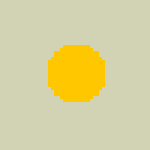

In [7]:
sim.visualizeMaterial()

Our simulation needs energy sources.  These are defined in a similar point-by-point fashion.  Note that the sources are defined with a complex number.  Values of `[1., 1.j, -1., -1.j]` all have the same magnitude, but are 90deg off of each other in phase. 

In [8]:
for x in range(0,20):
    sim.setPointSource((x, 21-x), 1.)
for x in range(0,20):
    sim.setPointSource((x+1, 21-x), -1.)

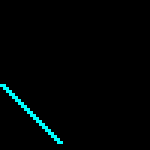

In [9]:
sim.visualizeSources()

These sources will generate waves which we will calculate in a second.  First we must define what we which they would do.  This is done by defining the complex value wave value at a series of points in space.  How well a design does will be depend on how close the fields are to the goal values at the designated points.

In [10]:
sim.setGoalPoint((35,35), 1.+0.j)

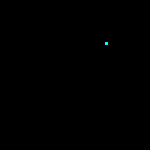

In [11]:
sim.visualizeGoal()

We then build all of the equations which define the physics and solve it.

In [12]:
sim.buildEquations()
sim.solve()

Not much appeared to happen, however internal values matrices were populated with the field solution.  If it went poorly, you might get an error message saying `"FAILED!!!"`.  We can observ the field.  Notice the wave eminating from our line of sources in the lower left corner.  Also note how our glass disk focuses the wave to a point near the upper right hand corner.

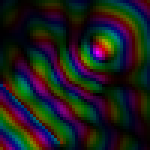

In [13]:
sim.visualizeFields()

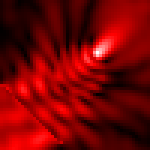

In [14]:
sim.visualizeFieldsMag()

We can compute the overlap with our goal points.  Lower scores are better.

In [15]:
sim.getScore()

0.8253160922704968

Now we can replace the "variable" portion of our design with something else.  This is the part inside `varBox` defined at instantiation.

While the material permittivity is a complex number, this doesn not lend itself to machine learning weight vectors.  Rather, we will use `getVarMat1D()` to obtain a 1D vector of values on the range [0,1] where 0 represents `epsStart` and 1 represents `epsEnd`.

Let's begin by probing the size of the array and then building a list of random values of similar size.

In [16]:
varSize = sim.getVarMat1D().size
newW = np.random.rand(varSize);

Now let's use that weight vector to alter the design.

In [17]:
sim.setVarMat1D(newW)

In [ ]:
sim.v

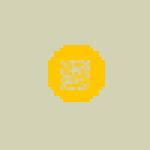

In [18]:
sim.visualizeMaterial()

... and solve it...

In [29]:
sim.buildEquations()
sim.solve()

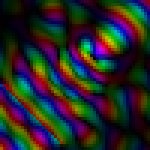

In [30]:
sim.visualizeFields()

... and score it.

In [31]:
sim.getScore()

0.66696671102494298

And this design appears to actually work better.